In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SENT_LENGTH = 200
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
cd /content/drive/My Drive


/content/drive/My Drive


In [5]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

In [6]:
reviews_df = pd.read_csv('Hotel_Reviews.csv')
print(reviews_df.dtypes)
reviews_df = reviews_df.dropna()
reviews_df = reviews_df.reset_index(drop=True)
print('Shape of dataset ',reviews_df.shape)
print(reviews_df.columns)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object
Shape of dataset  (512470, 17)
Index(['Hotel_Address', 'Additional_N

In [7]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews] 
cleaned_negative_reviews = [clean(r) for r in negative_reviews] 

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [8]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(p)
    else : 
        reviews_text.append(n)
        reviews_text.append(p)



In [9]:
# Preprocessing training data
training_df = reviews_df.loc[:10000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [10]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using Theano backend.


In [11]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [12]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [13]:
sentiment_df = sentiment_df.dropna()
sentiment_df = sentiment_df.reset_index(drop=True)
print('Shape of dataset ',sentiment_df.shape)
print(sentiment_df.columns)
print('No. of unique classes',len(set(sentiment_df['labels'])))

Shape of dataset  (16782, 2)
Index(['reviews', 'labels'], dtype='object')
No. of unique classes 2


In [14]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [15]:
macronum=sorted(set(sentiment_df['labels']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [16]:
def fun(i):
    return macro_to_id[i]

sentiment_df['labels']=sentiment_df['labels'].apply(fun)

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
for i in range(sentiment_df.reviews.shape[0]):
    text = BeautifulSoup(sentiment_df.reviews[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in sentiment_df['labels']:
    labels.append(i)

In [26]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 76612 unique tokens.


In [28]:
reviews = [ str(r) for r in sentiment_df['reviews'].values]
labels = sentiment_df['labels'].values

for idx, review in enumerate(text_reviews):
    words = text_to_word_sequence(review)
    if(len(words) > 40): 
        words = words[:40]
        text_reviews[idx] = ' '.join(words)

oneHotReviews = tokenizer.texts_to_sequences(reviews)
encodedReviews = keras.preprocessing.sequence.pad_sequences(oneHotReviews, maxlen=40, padding='post')

X_train, X_test, y_train, y_test = train_test_split(encodedReviews, labels, test_size=0.33, random_state=42)

In [21]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [23]:
text_reviews = [str(r) for r in reviews_text_df['reviews_text'].values]

sentences = []

for review in text_reviews:
    words = text_to_word_sequence(review)
    sentences.append(words)

embeddings_model = Word2Vec(sentences, min_count=1, sg=1, size=128)
words = list(embeddings_model.wv.vocab)
print('{} WORDS '.format(len(words)))
print('Printing first 100:')
print(words[:100])

76612 WORDS 
Printing first 100:
['rooms', 'are', 'a', 'bit', 'tired', 'and', 'showing', 'their', 'age', 'but', 'still', 'nice', 'spacious', 'really', 'needs', 'to', 'offer', 'free', 'wifi', 'these', 'days', 'pleasant', 'quiet', 'location', 'near', 'hyde', 'park', 'notting', 'hill', 's', 'kensington', 'museums', 'tube', 'station', 'walkable', 'centre', 'of', 'london', 'if', 'reasonably', 'fit', 'keeps', 'me', 'coming', 'back', 'with', 'biz', 'holiday', 'trips', 'coffee', 'shop', 'in', 'foyer', 'very', 'good', 'breakfast', 'options', 'no', 'included', 'dining', 'facilities', 'due', 'refurb', 'room', 'sevice', 'menu', 'didn', 't', 'do', 'so', 'waste', 'time', 'bath', 'mat', 'flannel', 'not', 'returned', 'everything', 'was', 'great', 'the', 'much', 'smaller', 'than', 'one', 'we', 'had', 'last', 'excellent', 'superb', 'historic', 'building', 'helpful', 'staff', 'my', 'favourite', 'hotels', 'enough', 'at', 'were']


In [24]:
import keras
# Querying SQLlite database to extract needed words embeddings
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_reviews)
vocabSize = len(tokenizer.word_index) + 1
vocabSize

76613

In [31]:
vocabSize = len(tokenizer.word_index) + 1
print(vocabSize)

# Recreating embeddings index based on Tokenizer vocabulary
word2vec_vocabulary = embeddings_model.wv.vocab
embeddingIndex = dict()
counter = 0
for word, i in tokenizer.word_index.items():
    if word in word2vec_vocabulary :
        embeddingIndex[word] = embeddings_model[word]
    else:
        counter += 1

print("{} words without pre-trained embedding!".format(counter))
    
# Prepare embeddings matrix
embeddingMatrix = zeros((vocabSize, 128))
for word, i in tokenizer.word_index.items():
    embeddingVector = embeddingIndex.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

76613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


0 words without pre-trained embedding!


In [32]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import GRU
from keras.layers import LSTM

from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
maxlen=40
max_features=40000
batch_size=32
filters = 256
pool_size = 2
gru_node = 256

model=keras.models.Sequential()
model.add(keras.layers.Embedding(vocabSize, 128, weights=[embeddingMatrix], input_length=40, trainable=True))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(gru_node, recurrent_dropout=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/layers/recurrent.py:2208: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '
/usr/local/lib/python3.6/dist-packages/keras/layers/recurrent.py:2208: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           9806464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 256)           65792     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 256)           131328    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 256)           

In [35]:
model.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=5,
                              batch_size=128,
                              verbose=2)

predicted = model.predict(X_test)

predicted = np.argmax(predicted, axis=1)
print(metrics.classification_report(y_test, predicted))

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 11243 samples, validate on 5539 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


 - 83s - loss: 0.4714 - accuracy: 0.7858 - val_loss: 0.2568 - val_accuracy: 0.9031
Epoch 2/5
 - 81s - loss: 0.2271 - accuracy: 0.9170 - val_loss: 0.2123 - val_accuracy: 0.9204
Epoch 3/5
 - 81s - loss: 0.1994 - accuracy: 0.9296 - val_loss: 0.1953 - val_accuracy: 0.9260
Epoch 4/5
 - 81s - loss: 0.1737 - accuracy: 0.9404 - val_loss: 0.1951 - val_accuracy: 0.9260
Epoch 5/5
 - 80s - loss: 0.1596 - accuracy: 0.9458 - val_loss: 0.1884 - val_accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2500
           1       0.95      0.92      0.93      3039

    accuracy                           0.93      5539
   macro avg       0.93      0.93      0.93      5539
weighted avg       0.93      0.93      0.93      5539



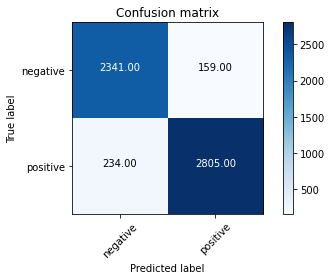

In [36]:
predictions = model.predict_classes(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
title = 'Confusion matrix'
cmap = plt.cm.Blues
classes=["negative","positive"]
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [37]:
 loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

  96/5539 [..............................] - ETA: 13s

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


5539/5539 [==============================] - 13s 2ms/step
Test Loss: 0.18840583140377878
Test Accuracy: 0.9290485382080078
